In [1]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource


%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [2]:
import glob
plt.style.use("ggplot")
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
# import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
import pandas as pd

from torch.optim.optimizer import Optimizer, required
import numpy as np
import random
dataset_="CIFAR10"
# import autograd_hacks
# from collections import defaultdict
# import sys

test_loader=[]
batch_size_ = 128
train_loader=[]
if dataset_=="CIFAR10":
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                              shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=128,
                                             shuffle=False)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # inputs, labels = data[0].to(device), data[1].to(device)
else:
    print("test2")
    mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
    mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
    train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



Files already downloaded and verified
Files already downloaded and verified


In [3]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
model_cnn=[]

if dataset_ == "CIFAR10" :
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x
    model_cnn = Net()
    model_cnn.to(device)
else:
   model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

def epoch(loader, model, opt=None):

    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [5]:
from torch.distributions import Normal

import numpy as np
class SGD_LD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).
    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf
    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.
        Considering the specific case of Momentum, the update can be written as
        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + g_{t+1}, \\
                p_{t+1} & = p_{t} - \text{lr} * v_{t+1},
            \end{aligned}
        where :math:`p`, :math:`g`, :math:`v` and :math:`\mu` denote the
        parameters, gradient, velocity, and momentum respectively.
        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form
        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + \text{lr} * g_{t+1}, \\
                p_{t+1} & = p_{t} - v_{t+1}.
            \end{aligned}
        The Nesterov version is analogously modified.
    """

    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGD_LD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD_LD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                # p.add_(d_p, alpha=-group['lr'])
                size = d_p.size()
                langevin_noise = Normal(
                        torch.zeros(size),
                        torch.ones(size) / np.sqrt(group['lr'])
                    )
                p.data.add_(d_p + .008*langevin_noise.sample().cuda(),alpha=-group['lr'])

        return loss


In [6]:
optims= [SGD_LD(model_cnn.parameters(),lr=.01),
optim.SGD(model_cnn.parameters(), lr=0.01),
         optim.SGD(model_cnn.parameters(), lr=0.01,momentum=0.9),
         optim.Adam(model_cnn.parameters(), lr=0.001, betas=(0.9, 0.999))]
opts_=["SGLD","SGD","SGD with momentum =0.9","ADAM lr=0.001, betas=(0.9, 0.999)"]
for opt,opt_ in zip(optims,opts_):


    for i in range(4):
        filename=opt_+"/Trial_"+str(i)+'_'+dataset_+'_'+str(batch_size_)+'_'+opt_+'.csv'
        train_err=[]
        test_err=[]
        train_err_track, train_loss_track, = [],[]
        test_err_track, test_loss_track,  = [],[]
        for t in range(10):
            train_err, train_loss = epoch(train_loader, model_cnn, opt)
            test_err, test_loss = epoch(test_loader, model_cnn)
            if opt_ =="SGD":
                if t == 4:
                    for param_group in opt.param_groups:
                        param_group["lr"] *= 1e-2
            print(*("{:.6f}".format(i) for i in (train_err, test_err, )), sep="\t")
            train_err_track.append(train_err)
            train_loss_track.append(train_loss)

            test_err_track.append(test_err)
            test_loss_track.append(test_loss)

        Results_plot = pd.DataFrame({'Train_Correct' : train_err_track,
                                     'Train_Xentropy': train_loss_track,
                                     'Test_Correct' : test_err_track,
                                     'Test_Xentropy': test_loss_track}
                                     )
        Results_plot.to_csv(filename, mode='a', header=True)

        column_names = ["OPT", "Train", "Test"]
        dic = {dataset_:[opt_,train_err,test_err]}

        df = pd.DataFrame.from_dict(dic,orient='index',columns=column_names)

        df.to_csv('Experiment_results.csv', mode='a', header=False)

        model_cnn.apply(weight_reset)

0.899680	0.900000
0.885980	0.830900
0.809220	0.759000
0.718240	0.693900
0.674520	0.668200
0.632440	0.632000
0.599900	0.581400
0.576860	0.565400
0.560260	0.547400
0.545620	0.536500
0.874980	0.867500
0.871820	0.863600
0.797280	0.735100
0.730880	0.708700
0.699300	0.682400
0.656040	0.644000
0.613000	0.591300
0.585000	0.579600
0.566300	0.562000
0.547600	0.547400
0.872700	0.857900
0.840000	0.813800
0.787340	0.730700
0.707920	0.684500
0.670240	0.644000
0.646360	0.636100
0.619880	0.607500
0.600680	0.598300
0.579260	0.586200
0.558940	0.550700
0.896140	0.879800
0.881920	0.878900
0.839500	0.807400
0.768340	0.729100
0.705180	0.679700
0.658780	0.638800
0.620180	0.587200
0.593640	0.577600
0.571360	0.565200
0.552480	0.543700
0.900440	0.900800
0.893660	0.860800
0.817540	0.788800
0.747480	0.707800
0.694540	0.679100
0.667700	0.687300
0.642180	0.626500
0.616580	0.603100
0.590900	0.586200
0.569660	0.572500
0.849180	0.820100
0.787100	0.732100
0.714960	0.689500
0.677880	0.650900
0.644740	0.630100
0.621960	0

In [15]:
def getDAtaframe(folderPath):
    all_files = glob.glob(folderPath + "/*.csv")
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)
    mean =pd.concat(li).groupby(level=0).mean()
    return mean;
adamPAth= "ADAM lr=0.001, betas=(0.9, 0.999)"
SGDwMPath = "SGD with momentum =0.9"
SGDpath = "SGD"
SGLDpath = "SGLD"

SGDwM = getDAtaframe(SGDwMPath)
ADAM = getDAtaframe(adamPAth)
SGD = getDAtaframe(SGDpath)
SGLD = getDAtaframe(SGLDpath)

Lables_fifth = [
    "ADAM",
    "SGD w/ M",
    "SGLD",
    "SGD"
]
MNISTDATA = [
    ADAM,
    SGDwM,
    SGLD,
    SGD
]
ADAM.head()

,Unnamed: 0,Train_Correct,Train_Xentropy,Test_Correct,Test_Xentropy
0,0,0.651700,1.758111,0.561125,1.529639
1,1,0.526995,1.443204,0.496300,1.371745
2,2,0.475760,1.322368,0.463675,1.293497
3,3,0.438010,1.229282,0.435250,1.222621
4,4,0.413225,1.162912,0.420375,1.188439


In [16]:
SGLD.head()

,Unnamed: 0,Train_Correct,Train_Xentropy,Test_Correct,Test_Xentropy
0,0,0.885875,2.302229,0.876300,2.298958
1,1,0.869930,2.287884,0.846800,2.267142
2,2,0.808335,2.213569,0.758050,2.122552
3,3,0.731345,2.041428,0.704050,1.959743
4,4,0.687310,1.901605,0.668575,1.841306


In [17]:
for frame in MNISTDATA:
    frame.columns = ['index',
                     'Train_Correct',
                     'Train_Xentropy',

                     'Test_Correct',
                     'Test_Xentropy',

                     ]
title = "MNIST 10 Epochs batch 128"

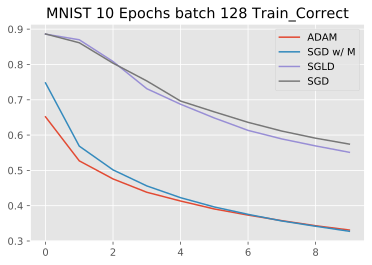

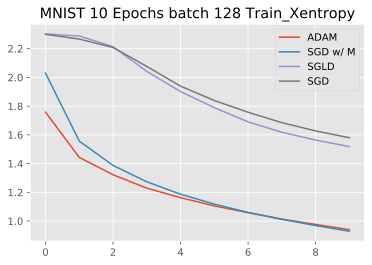

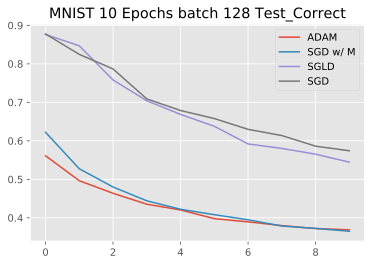

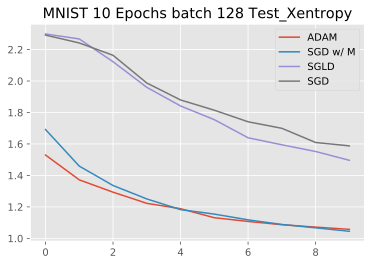

In [18]:
def plotThem(data, Column, LSlable, title,tail=0):
    fig =plt.figure()
    for frame,legend in zip(data,LSlable):
        plt.plot(frame.index[tail:],frame[Column][tail:],label=legend)
    plt.legend()
    if tail!=0:
        plt.title(title+" TAIL "+Column)
    else:
        plt.title(title+" "+Column)
    if tail !=0:
        plt.savefig(title + " Tail " + Column +".png")
    else:
        plt.savefig(title + " " + Column +".png")
    plt.show()

columnNames =[       'Train_Correct',
                     'Train_Xentropy',

                     'Test_Correct',
                     'Test_Xentropy',

                     ]

for graph in columnNames:
   plotThem(MNISTDATA,graph,Lables_fifth, title,tail=0)

